In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#SMOTE 
import imblearn
from imblearn.over_sampling import SMOTE

#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/glass/glass.csv


In [2]:
data = pd.read_csv('../input/glass/glass.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
#get information about the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


### **Checking null values**
Missing values in the dataset can cause problems. Before classification, the missing values problem should be solved.
There is no null value in the dataset.

In [4]:
data.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

The statistical results of the data can help us make some inferences about the dataset.
With describe() method, many information such as the mean values of the data, standard deviation values etc are displayed. 

For example it is seen that the highest mean value is in Si feature.

In [5]:
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### **Checking duplicate values**
Repeated data may prevent the model from producing correct results.
duplicated() method, it is checked whether there is a repeating value in the dataset. 


In [6]:
dups = data.duplicated()
print('Number of duplicate rows: %d' % dups.sum())

Number of duplicate rows: 1


In [7]:
#drop duplicated value
print('Number of rows before discarding duplicates = %d' % data.shape[0])

data2 = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % data2.shape[0])

Number of rows before discarding duplicates = 214
Number of rows after discarding duplicates = 213


### **Checking dataset imbalanced**

The sets of data in which classes are not evenly distributed, approximately the same number for its class are called imbalanced datasets.The high accuracy value of the model can be caused by a certain class.

value_counts() method shows how many samples it is for the glass type. Type 2 and Type 1 have more samples than other types.

In [8]:
data2.Type.value_counts()

2    76
1    69
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

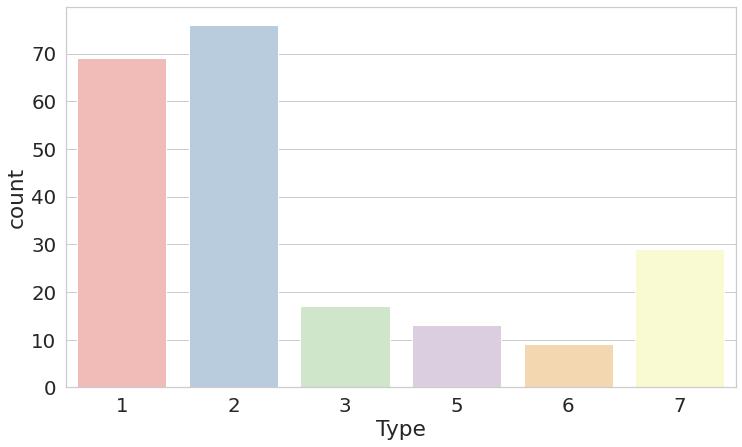

In [9]:
sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = 'Type', data = data2, palette = 'Pastel1')

### **Checking outliers**

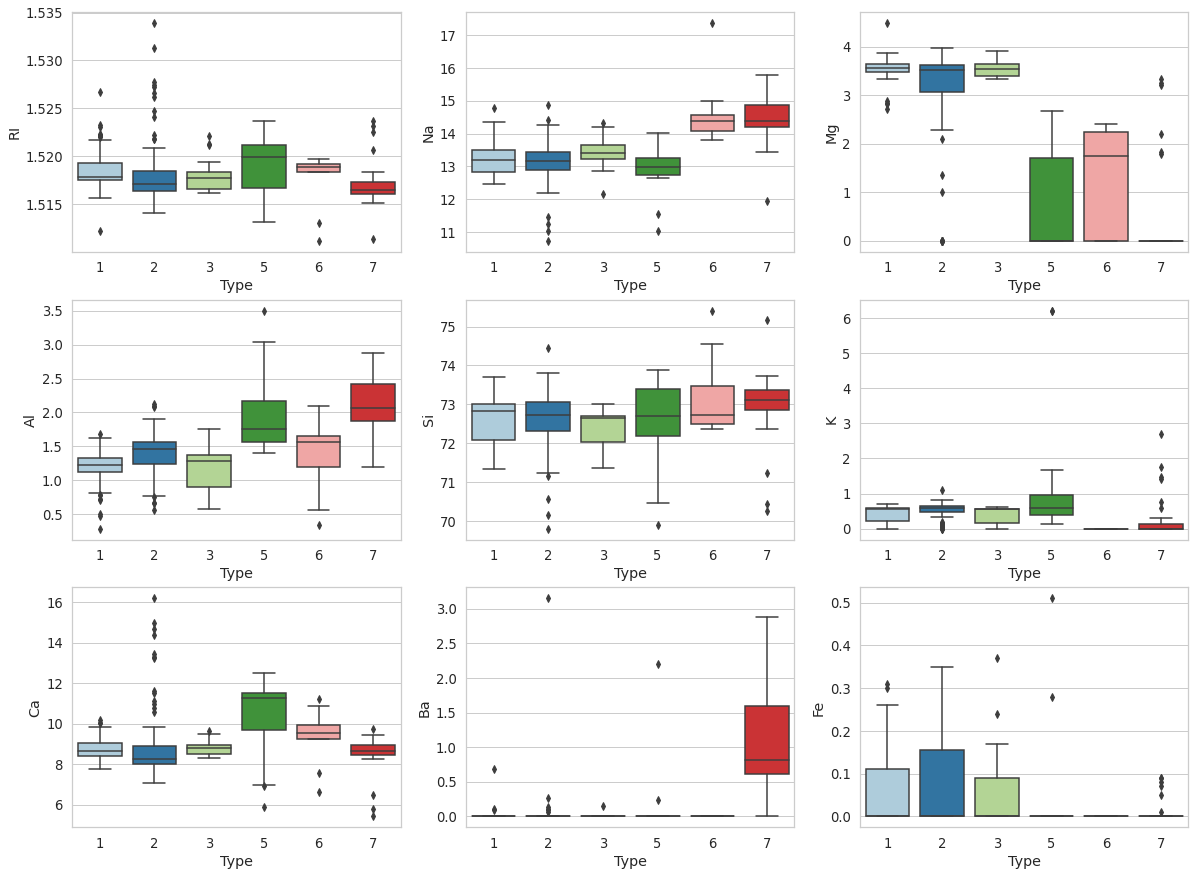

In [10]:
target_class_name = 'Type'
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

sns.set(style = 'whitegrid', font_scale = 1.2, palette = 'Paired')
plt.subplots(figsize = (20,15))

for i in range(1,10):
    plt.subplot(3,3,i)
    sns.boxplot(x = target_class_name, y = features[i-1], data = data2)


### **correlation coefficients**
Correlation is the relationship between two variables. Values above 0.70, 0.80 indicate a high correlation. Finding highly correlated features in the dataset can be misleading for the model. 
Attention should be paid to feature selection while applying the model.


There is a high correlation of 0.81 between Ca and RI in the dataset.
##### Ba - Al -> 0.48
##### Ba - Na -> 0.33
There is a negative correlation between Si and RI with a value of -0.54.

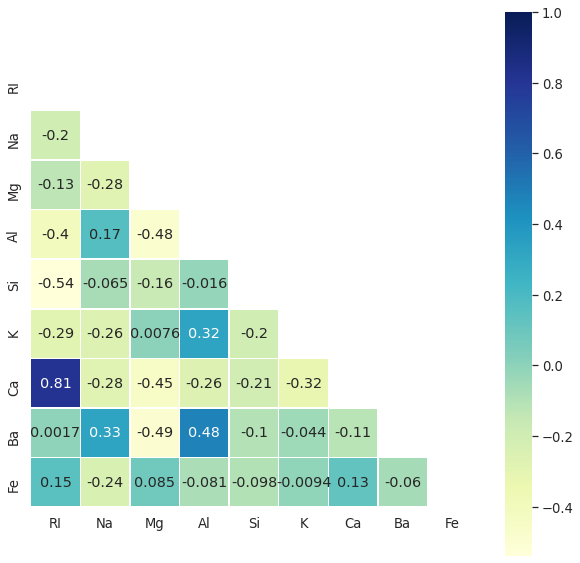

In [11]:
correlation = data2[features].corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize = (10, 10))
sns.heatmap(correlation, mask = mask, cmap = 'YlGnBu', annot = True, linewidth = .5, square = True)

It is set to be 80% training data and 20% test data.

In [12]:
X = pd.DataFrame(data2.drop(["Type"], axis = 1),
            columns=['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe'])
y = data2.Type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 40, stratify = y)

### K-Nearest Neighbors Classification
It is a widely used supervised machine learning algorithm. In the work of the algorithm, a value of k is determined, the meaning of k value is the number of elements to look at. When a value comes, the distance between the value is calculated by taking the nearest k elements. Euclidean, Manhattan, Minkowski and Hamming functions are used for distance calculation. After the distances are calculated, they are sorted and the corresponding value is assigned to the appropriate class.

With the help of GridSearchCV, after calculating the best value in the range of (1, 50) of the number of neighbors to be given to the model, the accuracy value was calculated as 0.7674.

In [13]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1,50)}
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)

n_neig = knn_cv_model.best_params_['n_neighbors']

In [14]:
knn_tuned = KNeighborsClassifier(n_neighbors = n_neig).fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score for KNN: {}'.format(knn_accuracy))

Accuracy score for KNN: 0.7674418604651163


Accuracy is the number of correctly predicted data points out of all the data points.
As a performance measure, accuracy is inappropriate for imbalanced classification problems. Therefore, it is necessary to evaluate the results of other metrics together.

The confusion matrix that enables the calculation of the metrics that measure the success of the classification models was created.

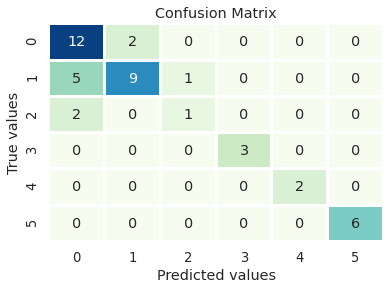

In [15]:
#Confusion Matrix of KNN
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, lw = 2, cbar = False, cmap = 'GnBu')
plt.ylabel('True values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')
plt.show()

An alternative to using classification accuracy is to use precision and recall metrics.

##### -> Precision quantifies the number of positive class predictions that actually belong to the positive class.
##### -> Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
##### -> F-Measure provides a single score that balances both the concerns of precision and recall in one number.

In [16]:
#Classification report for KNN
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.86      0.73        14
           2       0.82      0.60      0.69        15
           3       0.50      0.33      0.40         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6

    accuracy                           0.77        43
   macro avg       0.82      0.80      0.80        43
weighted avg       0.78      0.77      0.76        43



### SMOTE (Synthetic Minority Over-sampling Technique)

One of the methods that can be used to eliminate the imbalance in the data set is resampling. It has two methods:

The first method is to increase the data belonging to the minority classes to obtain classes with an equal number of data. It is called oversampling.

Another method is to obtain a balanced data set by extracting the data belonging to the weighted class from the data set. It is called undersampling.


The oversampling method was preferred because the number of samples in the data set used is small and the undersampling process will cause data loss. In order to apply this method, the SMOTE technique in imbalanced-learn library was used and synthetic data belonging to minority classes were produced.


Text(0.5, 1.0, 'Before SMOTE')

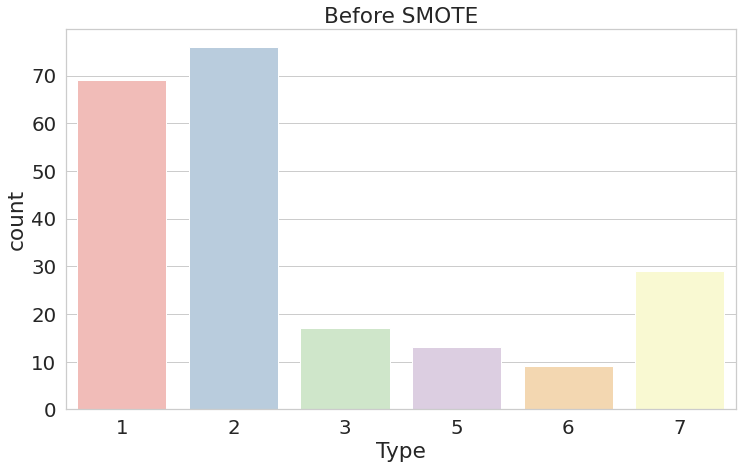

In [17]:
sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = y, palette = 'Pastel1').set_title('Before SMOTE')

Text(0.5, 1.0, 'After SMOTE')

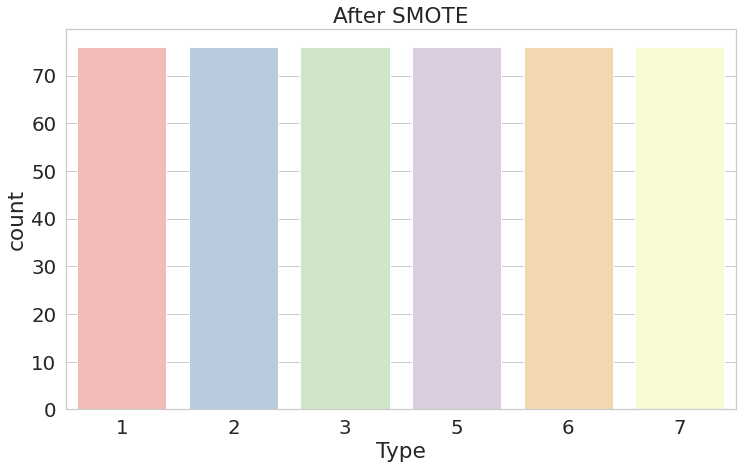

In [18]:
sm = SMOTE(sampling_strategy = 'not majority', random_state = 42)
x_res, y_res = sm.fit_resample(X, y)
y_res_df = pd.DataFrame(y_res)


sns.set(style = 'whitegrid', font_scale = 1.8)
plt.subplots(figsize = (12,7))
sns.countplot(x = y_res_df.Type, palette = 'Pastel1').set_title('After SMOTE')


In [19]:
print(x_res.shape)
print(y_res.shape)

y_res.value_counts()

(456, 9)
(456,)


7    76
6    76
5    76
3    76
2    76
1    76
Name: Type, dtype: int64

#### Standard Scaler

Situations such as the distribution of data and the scale differences between features are factors that affect the operation of algorithms. In this case, pulling the features into a common data range enables us to obtain more accurate results.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size = .2, random_state = 40, stratify = y_res)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### LDA (Linear Discriminant Analysis)
It is used as a size reduction technique. It reduces the size of the data set, maximizing the difference between classes. The goal is to prevent overfitting and reduce computational costs.

In the data set, 9 attributes were reduced to 5 significant components with the help of LDA.

In [21]:
lda = LDA(n_components = 5)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(364, 5)
(92, 5)


### KNN Classification again

In [22]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': np.arange(1,50)}
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)
n_neighbor = knn_cv_model.best_params_['n_neighbors']

In [23]:
knn_tuned = KNeighborsClassifier(n_neighbors = n_neighbor).fit(X_train,y_train)
knn_y_pred = knn_tuned.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)
print('Accuracy score for KNN: {}'.format(knn_acc))

Accuracy score for KNN: 0.8478260869565217


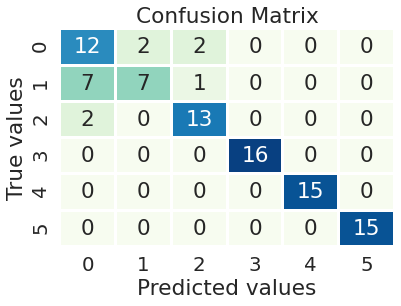

In [24]:
#Confusion Matrix of KNN
sns.heatmap(confusion_matrix(y_test, knn_y_pred), annot = True, lw = 2, cbar = False, cmap = 'GnBu')
plt.ylabel('True values')
plt.xlabel('Predicted values')
plt.title('Confusion Matrix')
plt.show()

In [25]:
#Classification report for KNN
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           1       0.57      0.75      0.65        16
           2       0.78      0.47      0.58        15
           3       0.81      0.87      0.84        15
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15

    accuracy                           0.85        92
   macro avg       0.86      0.85      0.85        92
weighted avg       0.86      0.85      0.84        92

